In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import display, HTML
import shap
import sys; sys.path.insert(0, '../..')
import math
import pandas as pd
from Server.NeuralNetwork.neuralnet import NeuralNet
shap.initjs()

'Dictionary for the class values and their names'

In [2]:
Label_to_value_dict={'X':0,
                     '1':1,
                     '2':2}

value_to_label_dict={0:'X',
                     1:'1',
                     2:'2'}
columns_convertor={'result_0':'X',
                   'result_1':'1',
                   'result_2':'2'}

 Loading and spliting the data

In [3]:
COLUMNS_NAMES=['away_att','away_def','away_mid',
               'away_team_rank','away_team_received',
               'away_team_scored','home_att',
               'home_def','home_mid','home_team_rank','home_team_received','home_team_scored','result','away_odds_n','draw_odds_n','home_odds_n']
FEATURES_NAME=['away_att','away_def','away_mid',
               'away_team_rank','away_team_received',
               'away_team_scored','home_att',
               'home_def','home_mid','home_team_rank','home_team_received','home_team_scored','away_odds_n','draw_odds_n','home_odds_n']


In [4]:
#Load the data
data = pd.read_csv("../mainTableCSV.csv")[COLUMNS_NAMES]
X=data.loc[:,FEATURES_NAME]
Y=data.loc[:,'result':'result']

In [5]:
#convert categorical to numerical value and encode
Y['result']=Y['result'].map(Label_to_value_dict)
Y = pd.get_dummies(Y,columns=['result'], prefix='result')
Y.rename(columns=columns_convertor,inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
#splitting the data to train-test datasets
Split_point=math.ceil(data.shape[0]*0.8)
x_train=X[0:Split_point]
y_train=Y[0:Split_point]

x_test=X[Split_point:]
y_test=Y[Split_point:]

feature_names=FEATURES_NAME


In [17]:
#Training the neural network
EPOCHS=40
ann=NeuralNet(x_train.shape[1])
ann.train(x_train,y_train,EPOCHS)

Batch Size:  8
Epoch 1/40
4652/4652 [==============================] - 6s 1ms/step - loss: 0.9285 - accuracy: 0.5713
Epoch 2/40
4652/4652 [==============================] - 7s 1ms/step - loss: 0.8663 - accuracy: 0.5989
Epoch 3/40
4652/4652 [==============================] - 9s 2ms/step - loss: 0.8535 - accuracy: 0.6029
Epoch 4/40
4652/4652 [==============================] - 8s 2ms/step - loss: 0.8490 - accuracy: 0.6046
Epoch 5/40
4652/4652 [==============================] - 7s 1ms/step - loss: 0.8467 - accuracy: 0.6061
Epoch 6/40
4652/4652 [==============================] - 6s 1ms/step - loss: 0.8452 - accuracy: 0.6073
Epoch 7/40
4652/4652 [==============================] - 6s 1ms/step - loss: 0.8441 - accuracy: 0.6079
Epoch 8/40
4652/4652 [==============================] - 6s 1ms/step - loss: 0.8431 - accuracy: 0.6079
Epoch 9/40
4652/4652 [==============================] - 4s 914us/step - loss: 0.8424 - accuracy: 0.6086
Epoch 10/40
4652/4652 [==============================] - 4s 760us

In [8]:
# we use the first 1000 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(ann.model,x_train.sample(1000).to_numpy())

    Force Diagrams for all classes (change sample to individual match)

In [9]:
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
number_of_samples = 1
# the sample should change to the match's feature to be explained
sample = x_test.sample(number_of_samples)
result=y_test.loc[sample.index]
prediction=pd.DataFrame(data=ann.predict(sample),index=sample.index,columns=['pred_X','pred_1','pred_2'])
print('Sample')
display(sample)
print('Actual Result')
display(result)
print('Prediction')
display(prediction)


Sample


,away_att,away_def,away_mid,away_team_rank,away_team_received,away_team_scored,home_att,home_def,home_mid,home_team_rank,home_team_received,home_team_scored,away_odds_n,draw_odds_n,home_odds_n
37456,72,72,73,2,0.333333,2.0,83,82,85,7,1.666667,1.666667,0.507834,0.27135,0.220815


Actual Result


,X,1,2
37456,1,0,0


Prediction


,pred_X,pred_1,pred_2
37456,0.29319,0.313711,0.3931


In [10]:
to_explain=sample.to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain
feature_names=FEATURES_NAME

for which_class in range(0,3):
    print(f'\tClass number {which_class} : {value_to_label_dict[which_class]}')
    display(shap.force_plot(base_value=explainer.expected_value[which_class].numpy(),
                            shap_values=shap_values[which_class],
                            features=features,
                            feature_names=feature_names,out_names=value_to_label_dict[which_class]))

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
	Class number 0 : X


	Class number 1 : 1


	Class number 2 : 2


Summary plot for each class

	Class number 0 : X


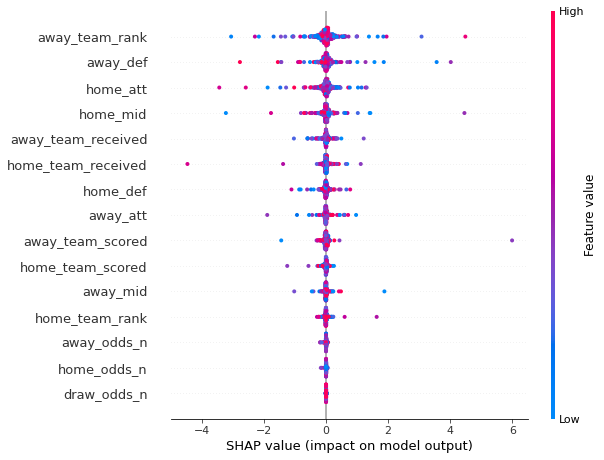

None

	Class number 1 : 1


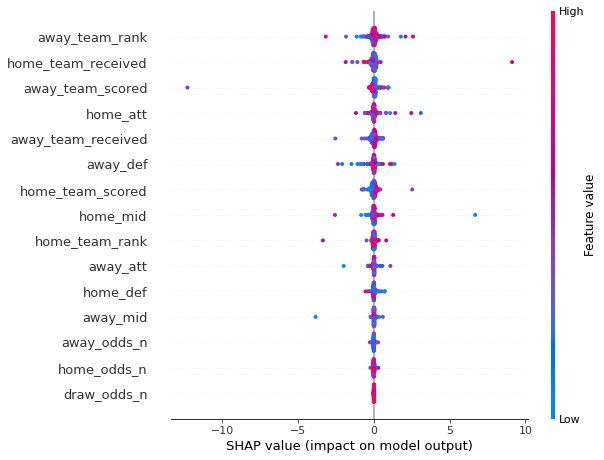

None

	Class number 2 : 2


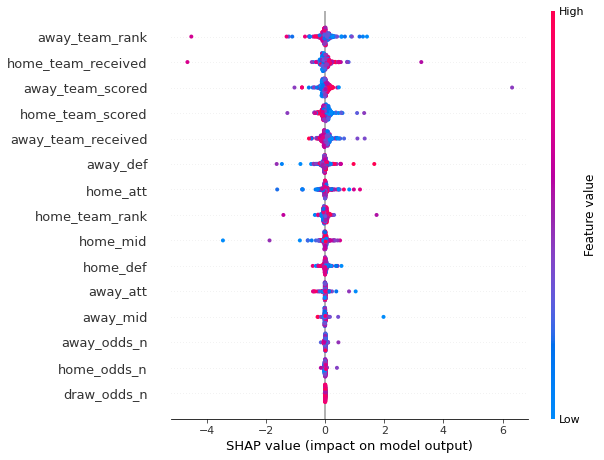

None

In [11]:
number_of_samples=300
to_explain=x_test.sample(number_of_samples).to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain

for which_class in range(0,3):
    print(f'\tClass number {which_class} : {value_to_label_dict[which_class]}')
    display(shap.summary_plot(shap_values=shap_values[which_class],
                                features=features,
                                feature_names=feature_names))

Summary plot for all the classes

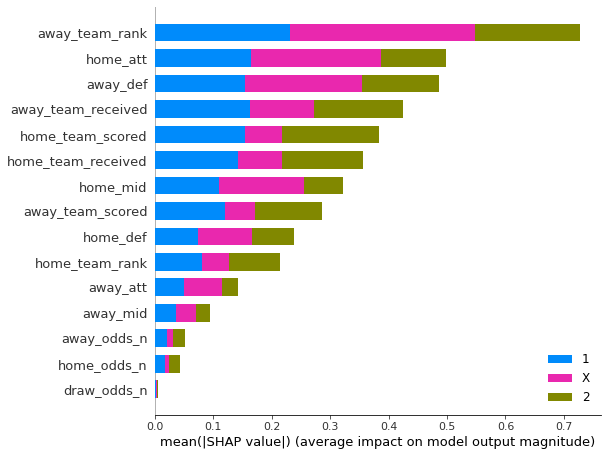

None

In [12]:
to_explain=x_test.to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain
display(shap.summary_plot(shap_values=shap_values,features=features,feature_names=feature_names,class_names=value_to_label_dict))

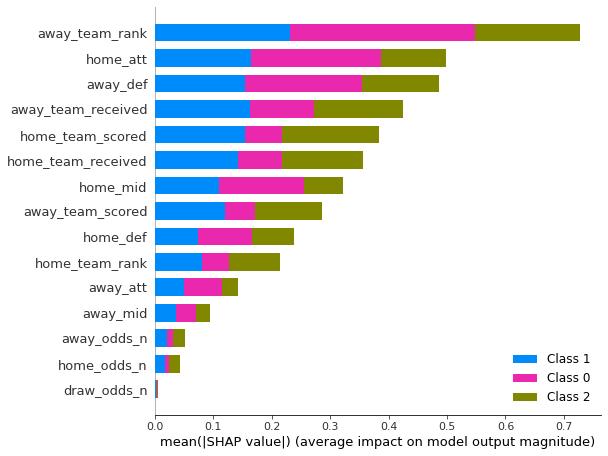

None

In [13]:
to_explain=x_test.to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain
display(shap.summary_plot(shap_values=shap_values,features=features,feature_names=feature_names))

Section for single record explanation

In [18]:
#insert the record's detail
record={'away_att':[76],
        'away_def':[75],
        'away_mid':[73],
        'away_team_rank':[6],
        'away_team_received':[1.333],
        'away_team_scored':[2],
        'home_att':[83],
        'home_def':[82],
        'home_mid':[83],
        'home_team_rank':[2],
        'home_team_received':[2],
        'home_team_scored':[0.666],
        'away_odds_n':[0.161],
        'draw_odds_n':[0.099],
        'home_odds_n':[0.739]}
record=pd.DataFrame(data=record)

#preform prediction
prediction=pd.DataFrame(data=ann.predict(record),columns=['pred_X','pred_1','pred_2'])
display(prediction)

shap_values = explainer.shap_values(X=record.to_numpy(),check_additivity=False)
features=record.to_numpy()
feature_names=list(record.columns)

for which_class in range(0,3):
    print(f'\tClass number {which_class} : {value_to_label_dict[which_class]}')
    display(shap.force_plot(base_value=explainer.expected_value[which_class].numpy(),
                            shap_values=shap_values[which_class],
                            features=features,
                            feature_names=feature_names,
                           out_names=value_to_label_dict[which_class]))


,pred_X,pred_1,pred_2
0,0.334202,0.271458,0.394341


	Class number 0 : X


	Class number 1 : 1


	Class number 2 : 2
